# Getting Started

This notebook is a tutorial for how to load and run `traffic_prophet`, based on . It assumes you've already installed the Python package dependencies listed in `requirements.txt`, and created (or refreshed, if necessary) the tables

```
prj_volume.tp_centreline_lonlat.sql
prj_volume.tp_centreline_volumes.sql
prj_volume.tp_daily_volumes.sql
```

The creation scripts for these can be found in `input_data/flow`.

## Import Package

In [18]:
import sys
import pathlib
import configparser
import numpy as np
import pandas as pd
# The package's location relative to this Jupyter Notebook.
sys.path.append('../../')

Load your Postgres credentials using `ConfigParser`.

In [2]:
config = configparser.ConfigParser()
config.read(pathlib.Path.home().joinpath({YOUR CONFIG FILE}).as_posix());
postgres_settings = config['POSTGRES']

As it stands, Traffic Prophet does not have a single run command. Instead, submodules must be manually imported.

In [3]:
from traffic_prophet import connection
from traffic_prophet.countmatch import reader
from traffic_prophet.countmatch import permcount as pc
from traffic_prophet.countmatch import neighbour as nbr
import traffic_prophet.countmatch.matcher as mt

Import configuration dictionary:

In [4]:
from traffic_prophet import cfg
cfg.cm['verbose'] = True

Create connection objects for volume and lon-lat tables.

In [5]:
vol_conn = connection.Connection(postgres_settings, 'prj_volume.tp_daily_volumes_clean')
ll_conn = connection.Connection(postgres_settings, 'prj_volume.tp_centreline_lonlat')

## Run CountMatch

### Read in Data

In [6]:
%%time
tcs = reader.read(vol_conn)

CPU times: user 1min 17s, sys: 531 ms, total: 1min 18s
Wall time: 1min 32s


### Separate Short Term Traffic Counts (STTCs) from Permanent Counts (PTCs)

In [8]:
%%time
pc.get_ptcs_sttcs(tcs)

Processing permanent counts: 100%|██████████| 15559/15559 [00:41<00:00, 372.70it/s]

CPU times: user 41.4 s, sys: 922 ms, total: 42.3 s
Wall time: 41.8 s


### Determine Nearest PTC for each STTC

In [9]:
%%time
ptc_ids = np.unique(np.abs(list(tcs.ptcs.keys())))
nb = nbr.NeighbourLonLatEuclidean(ll_conn, 20, ptc_ids)
nb.find_neighbours()

CPU times: user 13.3 s, sys: 312 ms, total: 13.7 s
Wall time: 14.8 s


### Run Matching Algorithm

There are two matcher classes - `MatcherStandard`, which is based on TEPS, and `MatcherBagheri`, which is based on Bagheri et al. 2014's original formulation. `mb = mt.Matcher('Standard', tcs, nb)` creates a standard TEPS matcher; use `mb = mt.Matcher('Bagheri', tcs, nb)` to create a Bagheri-based one.

In [10]:
mb = mt.Matcher('Standard', tcs, nb)

In [11]:
%%time
results = mb.estimate_aadts(2016)

Estimating PTC AADTs: 100%|██████████| 152/152 [00:00<00:00, 33598.64it/s]

CPU times: user 12min 21s, sys: 29.8 s, total: 12min 50s
Wall time: 12min 48s


`results[0]` are the STTC AADTs; `results[1]` are the PTC AADTs.

## Visualize Results

To visualize the results, you'll need to install

```
geopandas>=0.7.0
matplotlib>=3.2.2
```

to read in geometries from the Postgres database.

In [50]:
import psycopg2
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline

In [33]:
# Average results across all directions of travel to get a AADT on (directionless) centreline dataset.
results_nodir = pd.concat([results[0], results[1]])
results_nodir['centreline_id'] = np.abs(results_nodir['Count ID'])
results_nodir = pd.DataFrame(
    results_nodir.groupby('centreline_id')['AADT Estimate'].mean())

In [42]:
sql_query = """SELECT geo_id,
       geom
FROM gis.centreline;"""

with psycopg2.connect(**vol_conn.credentials) as db_con:
    centreline_segments = gpd.read_postgis(sql_query, db_con)

In [43]:
centreline_segments = pd.merge(
    centreline_segments, results_nodir, left_on='geo_id',
    right_on='centreline_id', how='inner')

centreline_segments.to_crs({'init': 'epsg:3347'}, inplace=True)
centreline_segments['geom'] = centreline_segments.rotate(
    -28., origin=centreline_segments.unary_union.centroid)

/home/czhu/pythonenv/bditto/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


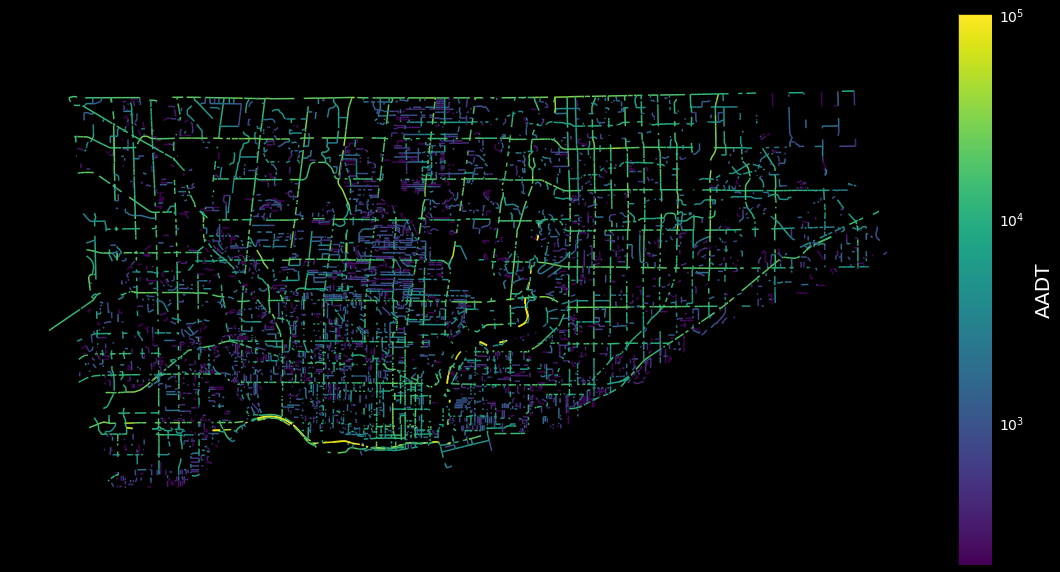

In [86]:
cmap = 'viridis'
vmin = 2e2
vmax = 1e5

fig = plt.figure(figsize=(16, 9))
fig.patch.set_facecolor('#000000')
ax1 = fig.add_axes([0.05, 0.05, 0.8, 0.85])
ax1.axis('off')

centreline_segments.plot(
    column='AADT Estimate', ax=ax1, cmap=cmap,
    norm=colors.LogNorm(vmin=vmin, vmax=vmax))

cax1 = fig.add_axes([0.875, 0.05, 0.03, 0.85])
cb1 = fig.colorbar(
    plt.cm.ScalarMappable(
        cmap=cmap,
        norm=colors.LogNorm(vmin=vmin, vmax=vmax)),
    cax=cax1)
cb1.set_label("AADT", labelpad=10, fontsize=20, color='w')
cax1.tick_params(labelsize=14, labelcolor='w')

At least on a log scale, that seems vaguely reasonable.